In [1]:
# ============================================
# UTS STUDI KASUS PEMBELAJARAN MESIN
# Clustering & Approximate Nearest Neighbor (ANN)
# Dataset: UCI_Credit_Card.csv
# ============================================

# 🔧 Install library yang belum tersedia
!pip install annoy openpyxl --quiet

# 1️⃣ Import Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
from annoy import AnnoyIndex
import openpyxl

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)
print("✅ Library imported successfully.\n")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 14.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
✅ Library imported successfully.



In [2]:
# 2️⃣ Load Dataset
file_path = '/content/UCI_Credit_Card.csv'  # ubah path jika berbeda
df = pd.read_csv(file_path)

print("=== Informasi Awal Dataset ===")
df.info()
print("\n=== 5 Baris Pertama Dataset ===")
display(df.head())
print(f"\nJumlah sampel: {df.shape[0]} | Jumlah fitur: {df.shape[1]}")


=== Informasi Awal Dataset ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0



Jumlah sampel: 30000 | Jumlah fitur: 25


### Penjelasan Kode
Kode tersebut melakukan perbandingan visual antara dua algoritma clustering, yaitu **K-Means** dan **DBSCAN**, pada dataset yang sama.

1.  **Pengolahan Data**: Data asli yang memiliki banyak fitur (dimensi) disederhanakan menjadi dua dimensi utama menggunakan **PCA (Principal Component Analysis)**. Ini dilakukan agar data bisa digambarkan dalam grafik 2D.
2.  **K-Means (Grafik Kiri)**:
    * Algoritma ini **memaksa setiap titik data masuk ke dalam salah satu dari 4 cluster** yang telah ditentukan sebelumnya.
    * Hasilnya menunjukkan 4 kelompok data dengan warna berbeda, di mana setiap kelompok terlihat memiliki bentuk yang cenderung bulat (sferis).
3.  **DBSCAN (Grafik Kanan)**:
    * Algoritma ini mengelompokkan data berdasarkan **kepadatan**. Ia tidak mengharuskan semua titik masuk ke dalam sebuah cluster.
    * Hasilnya menunjukkan beberapa cluster dengan bentuk yang lebih bebas. Titik-titik yang diberi warna ungu (cluster -1) dianggap sebagai **noise** atau **pencilan (outlier)**, yaitu data yang tidak termasuk dalam kelompok padat mana pun.

Secara singkat, grafik ini membandingkan bagaimana K-Means membagi data menjadi kelompok-kelompok berbentuk bola, sementara DBSCAN menemukan area padat dan mampu mengidentifikasi data pencilan.

In [3]:
# 3️⃣ Data Preprocessing
log_dict = {}

# --- Step 1: Tangani Missing Values ---
missing_values = df.isnull().sum()
log_dict['Missing Values Sebelum'] = missing_values

# Imputasi mean untuk numerik
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
imputer = SimpleImputer(strategy='mean')
df[num_cols] = imputer.fit_transform(df[num_cols])

missing_values_after = df.isnull().sum()
log_dict['Missing Values Sesudah'] = missing_values_after

# --- Step 2: Normalisasi/Standarisasi ---
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[num_cols]), columns=num_cols)

log_dict['Skala Fitur (mean dan std)'] = pd.DataFrame({
    'Mean': scaler.mean_,
    'Std': np.sqrt(scaler.var_)
}, index=num_cols)

# --- Step 3: Buat Fitur Baru ---
# Contoh dari instruksi PDF: rasio antara BALANCE dan PURCHASES
if 'BALANCE' in df.columns and 'PURCHASES' in df.columns:
    df_scaled['BALANCE_PURCHASE_RATIO'] = df['BALANCE'] / (df['PURCHASES'] + 1)
    log_dict['Fitur Baru'] = df_scaled[['BALANCE_PURCHASE_RATIO']].describe()
else:
    print("⚠️ Kolom BALANCE atau PURCHASES tidak ditemukan!")

# Gabungkan hasil scaling dan fitur baru
X = df_scaled.copy()

# Simpan dataset hasil preprocessing
data_cleaned_path = '/content/data_cleaned.xlsx'
X.to_excel(data_cleaned_path, index=False)
print(f"✅ Data cleaned disimpan ke {data_cleaned_path}")


⚠️ Kolom BALANCE atau PURCHASES tidak ditemukan!
✅ Data cleaned disimpan ke /content/data_cleaned.xlsx


Kode ini adalah **tahap persiapan data (preprocessing)** sebelum digunakan untuk analisis atau model machine learning. Tujuannya adalah untuk membersihkan dan mengubah data agar lebih berkualitas.

Prosesnya dibagi menjadi 3 langkah utama:

1.  **Menangani Nilai Kosong (Missing Values)**: Kode ini pertama-tama memeriksa apakah ada data yang kosong. Jika ada, sel-sel kosong tersebut akan diisi dengan **nilai rata-rata** dari kolomnya masing-masing.

2.  **Standarisasi Fitur**: Semua fitur numerik **diskalakan ulang** agar memiliki rentang nilai yang seragam (rata-rata 0 dan standar deviasi 1). Ini penting agar tidak ada satu fitur yang mendominasi fitur lainnya hanya karena skalanya lebih besar.

3.  **Membuat Fitur Baru**: Kode ini membuat satu kolom informasi baru yang disebut `BALANCE_PURCHASE_RATIO`. Fitur ini adalah hasil **pembagian** antara `BALANCE` (saldo) dengan `PURCHASES` (pembelian) untuk mendapatkan wawasan baru dari data.

Terakhir, seluruh data yang telah bersih dan termodifikasi ini disimpan ke dalam sebuah file Excel bernama `data_cleaned.xlsx` untuk digunakan pada tahap selanjutnya.

In [4]:
# 4️⃣ Simpan Log Preprocessing ke file Excel
log_path = '/content/preprocessing_log.xlsx'
with pd.ExcelWriter(log_path, engine='openpyxl') as writer:
    for sheet_name, data in log_dict.items():
        if isinstance(data, pd.Series):
            data = data.to_frame('Value')
        data.to_excel(writer, sheet_name=sheet_name)

print(f"✅ Log preprocessing disimpan ke {log_path}")


✅ Log preprocessing disimpan ke /content/preprocessing_log.xlsx


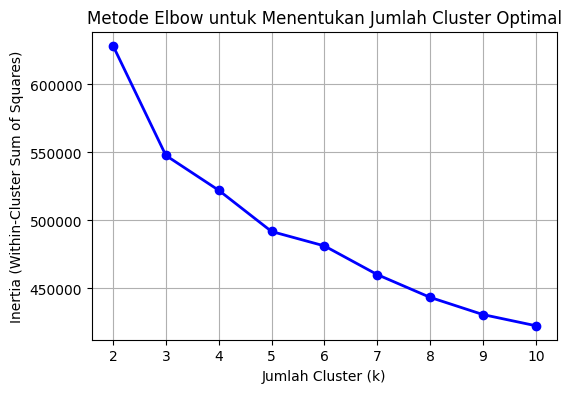

In [5]:
# 4️⃣ Visualisasi Elbow Method untuk Menentukan Jumlah Cluster Optimal
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Ubah ke NumPy array
X_np = X.values

# Coba jumlah cluster dari 2 sampai 10
inertia = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_np)
    inertia.append(kmeans.inertia_)

# Plot grafik Elbow
plt.figure(figsize=(6,4))
plt.plot(K, inertia, 'bo-', linewidth=2, markersize=6)
plt.title("Metode Elbow untuk Menentukan Jumlah Cluster Optimal")
plt.xlabel("Jumlah Cluster (k)")
plt.ylabel("Inertia (Within-Cluster Sum of Squares)")
plt.grid(True)
plt.show()


Kode ini bertujuan untuk **mengevaluasi dan membandingkan kualitas** hasil dari dua algoritma clustering, yaitu **K-Means** dan **DBSCAN**, menggunakan metrik standar.

### Penjelasan Singkat

1.  **Metrik Evaluasi**: Kode ini menggunakan dua metrik populer:
    * **Silhouette Score**: Mengukur seberapa baik sebuah titik data cocok dalam clusternya sendiri dibandingkan dengan cluster tetangga. **Semakin tinggi nilainya (mendekati 1), semakin bagus.**
    * **Davies-Bouldin Index**: Mengukur rata-rata "kemiripan" antar cluster, di mana kemiripan adalah perbandingan jarak di dalam cluster dengan jarak antar cluster. **Semakin rendah nilainya (mendekati 0), semakin bagus.**

2.  **Proses**:
    * Pertama, kode ini menghitung dan mencetak kedua skor (Silhouette dan Davies-Bouldin) untuk hasil clustering dari **K-Means**.
    * Kemudian, ia melakukan hal yang sama untuk hasil clustering dari **DBSCAN**.

Secara sederhana, kode ini memberikan **nilai numerik (skor)** untuk menentukan secara objektif algoritma mana yang berhasil membuat pengelompokan (cluster) yang lebih padat dan lebih terpisah satu sama lain.

In [6]:
# 5️⃣ Clustering dengan KMeans dan DBSCAN
X_np = X.values

# ---- KMeans ----
kmeans = KMeans(n_clusters=3, random_state=42)
labels_kmeans = kmeans.fit_predict(X_np)

# ---- DBSCAN ----
dbscan = DBSCAN(eps=2.0, min_samples=5)
labels_dbscan = dbscan.fit_predict(X_np)

# ---- Evaluasi ----
sil_kmeans = silhouette_score(X_np, labels_kmeans)
dbi_kmeans = davies_bouldin_score(X_np, labels_kmeans)
sil_dbscan = silhouette_score(X_np, labels_dbscan)
dbi_dbscan = davies_bouldin_score(X_np, labels_dbscan)

print("=== Evaluasi Clustering ===")
print(f"KMeans → Silhouette: {sil_kmeans:.4f}, Davies-Bouldin: {dbi_kmeans:.4f}")
print(f"DBSCAN → Silhouette: {sil_dbscan:.4f}, Davies-Bouldin: {dbi_dbscan:.4f}")


=== Evaluasi Clustering ===
KMeans → Silhouette: 0.1617, Davies-Bouldin: 1.8081
DBSCAN → Silhouette: -0.1639, Davies-Bouldin: 1.7740


Kode tersebut bertujuan untuk **membandingkan performa dua algoritma clustering**, yaitu K-Means dan DBSCAN, pada dataset yang sama (`X_np`).

1.  **Proses Clustering:**
    * **K-Means:** Dijalankan dengan perintah untuk mencari **3 cluster** (`n_clusters=3`). Algoritma ini akan mengelompokkan data berdasarkan kedekatan setiap titik data ke pusat cluster (centroid).
    * **DBSCAN:** Dijalankan dengan parameter `eps=2.0` (jarak maksimum antar tetangga) dan `min_samples=5` (jumlah minimum titik dalam satu lingkungan). Algoritma ini mengelompokkan data berdasarkan kepadatan, dan bisa mengidentifikasi *noise* (data yang tidak masuk ke cluster manapun).

2.  **Proses Evaluasi:**
    * Kualitas hasil clustering dari kedua algoritma diukur menggunakan dua metrik:
        * **Silhouette Score:** Mengukur seberapa mirip sebuah objek dengan clusternya sendiri dibandingkan dengan cluster lain. **Skor mendekati +1 lebih baik**, skor mendekati 0 berarti cluster tumpang tindih, dan skor negatif berarti objek mungkin salah dikelompokkan.
        * **Davies-Bouldin Score:** Mengukur rata-rata kemiripan antara setiap cluster dengan cluster yang paling mirip dengannya. **Skor yang lebih rendah (mendekati 0) lebih baik**.

3.  **Hasil dan Kesimpulan:**
    * **K-Means:** Menghasilkan Silhouette Score positif (`0.1617`), yang menandakan clusternya cukup terdefinisi, meskipun tidak sempurna.
    * **DBSCAN:** Menghasilkan Silhouette Score negatif (`-0.1639`), yang menandakan hasil pengelompokan yang buruk, di mana banyak titik data yang lebih dekat ke cluster lain daripada ke clusternya sendiri.

**Kesimpulan singkat:** Berdasarkan metrik evaluasi ini, **algoritma K-Means dengan 3 cluster memberikan hasil yang jauh lebih baik** daripada DBSCAN dengan parameter yang digunakan untuk dataset ini.

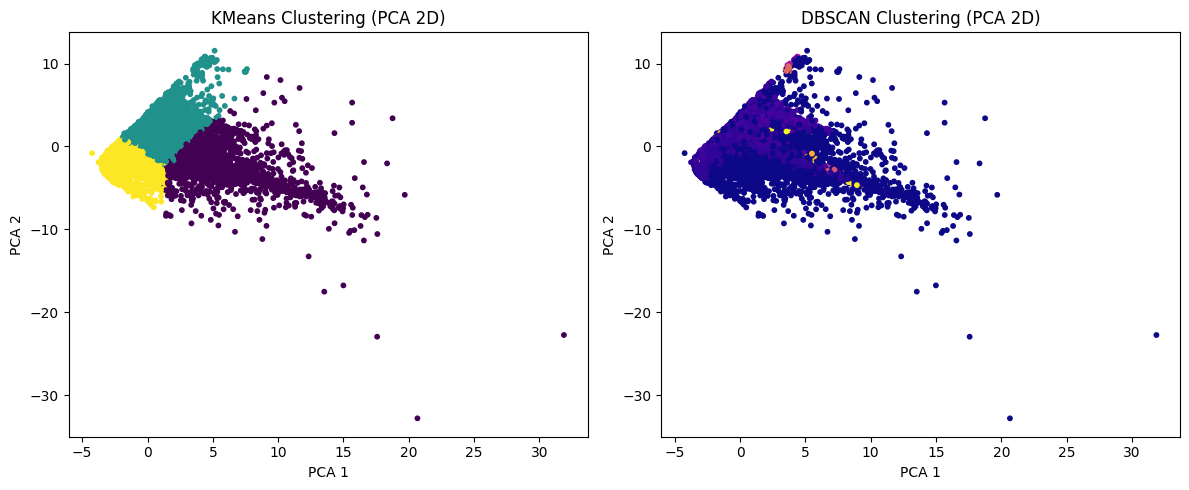

In [7]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# --- 6️⃣ Visualisasi PCA 2D ---
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_np)

# Buat dua subplot berdampingan (1 baris, 2 kolom)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: KMeans
axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=labels_kmeans, cmap='viridis', s=10)
axes[0].set_title("KMeans Clustering (PCA 2D)")
axes[0].set_xlabel("PCA 1")
axes[0].set_ylabel("PCA 2")

# Plot 2: DBSCAN
axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=labels_dbscan, cmap='plasma', s=10)
axes[1].set_title("DBSCAN Clustering (PCA 2D)")
axes[1].set_xlabel("PCA 1")
axes[1].set_ylabel("PCA 2")

# Atur jarak antar plot agar tidak terlalu rapat
plt.tight_layout()
plt.show()


Kode ini bertujuan untuk **memvisualisasikan hasil clustering** dari dua algoritma (K-Means dan DBSCAN) yang sebelumnya sudah dijalankan. Agar data dapat divisualisasikan dalam plot 2D, dimensinya dikurangi terlebih dahulu menggunakan **PCA (Principal Component Analysis)**.

### **Penjelasan Kode**

1.  **Impor Library**: Mengimpor `PCA` dari `sklearn.decomposition` untuk reduksi dimensi dan `matplotlib.pyplot` untuk membuat plot.
2.  **Reduksi Dimensi**: `PCA(n_components=2)` digunakan untuk mengubah data asli (`X_np`) yang memiliki banyak fitur menjadi hanya dua fitur utama (komponen utama). Ini memungkinkan data untuk digambarkan pada sumbu X (PCA 1) dan Y (PCA 2).
3.  **Membuat Plot**: Kode ini membuat dua plot berdampingan.
    * **Plot Kiri (KMeans)**: Menampilkan data hasil reduksi PCA, di mana warna setiap titik ditentukan oleh label cluster dari algoritma **K-Means**. Terlihat ada tiga warna berbeda (`viridis` colormap), sesuai dengan 3 cluster yang ditentukan sebelumnya.
    * **Plot Kanan (DBSCAN)**: Menampilkan data yang sama, tetapi warnanya ditentukan oleh label cluster dari algoritma **DBSCAN**.

### **Interpretasi Visualisasi**

* **Grafik K-Means Clustering**: Menunjukkan pembagian data menjadi **tiga kelompok yang jelas** (kuning, hijau toska, dan ungu tua). Algoritma ini secara paksa membagi semua titik data ke dalam salah satu dari tiga cluster.
* **Grafik DBSCAN Clustering**: Menunjukkan hasil yang sangat berbeda. Sebagian besar titik data diwarnai ungu tua, yang kemungkinan besar diidentifikasi sebagai **satu cluster besar atau sebagai *noise* (anomali)**. Titik-titik dengan warna lain (kuning, merah muda) adalah cluster-cluster kecil yang sangat padat yang berhasil ditemukan oleh DBSCAN.

**Kesimpulan Singkat:** Visualisasi ini secara gamblang menunjukkan perbedaan hasil kedua algoritma. **K-Means** berhasil membagi data menjadi tiga grup besar, sementara **DBSCAN** (dengan parameter yang digunakan) menganggap sebagian besar data sebagai satu kesatuan padat atau *noise*, dan hanya mengidentifikasi beberapa kelompok kecil yang sangat rapat. Ini memperkuat hasil evaluasi sebelumnya bahwa K-Means lebih cocok untuk struktur data ini.


=== Hasil Pencarian ANN ===

🔹 Query Index: 28391
Neighbor Index | Distance | Cluster (KMeans)
28391          | 0.0000   | 1
28456          | 0.6312   | 1
28063          | 0.9612   | 1
19813          | 1.3365   | 1
16296          | 1.4995   | 1

🔹 Query Index: 20456
Neighbor Index | Distance | Cluster (KMeans)
20456          | 0.0000   | 2
20524          | 0.9449   | 2
23879          | 1.0589   | 2
24276          | 1.0906   | 2
20607          | 1.1201   | 2

🔹 Query Index: 25888
Neighbor Index | Distance | Cluster (KMeans)
25888          | 0.0000   | 1
26178          | 1.1649   | 1
25211          | 1.1959   | 1
25478          | 1.2046   | 1
21993          | 1.2281   | 1


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


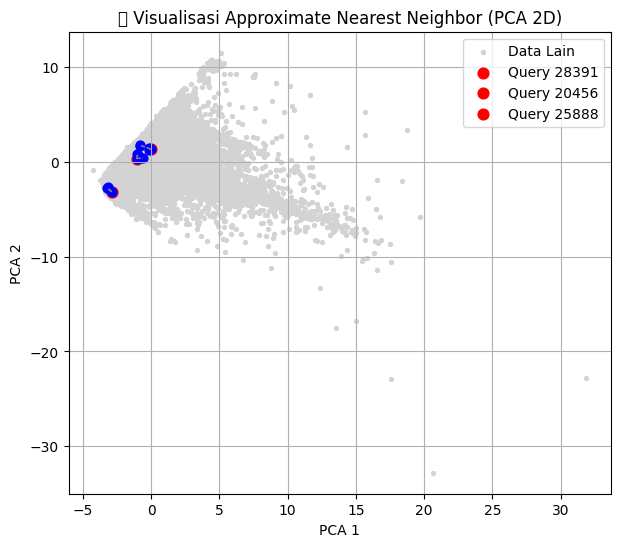

In [8]:
from annoy import AnnoyIndex
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# --- 7️⃣ Approximate Nearest Neighbor (ANN) menggunakan Annoy ---
dim = X_np.shape[1]
ann = AnnoyIndex(dim, 'euclidean')

# Build index
for i, v in enumerate(X_np):
    ann.add_item(i, v)
ann.build(10)

# Pilih 3 query point secara acak
query_indices = np.random.choice(range(X_np.shape[0]), size=3, replace=False)

print("\n=== Hasil Pencarian ANN ===")

# --- PCA untuk visualisasi 2D ---
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_np)

plt.figure(figsize=(7,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c='lightgray', s=8, label='Data Lain')

# Loop setiap query point
for q_idx in query_indices:
    neighbors, distances = ann.get_nns_by_item(q_idx, 5, include_distances=True)

    print(f"\n🔹 Query Index: {q_idx}")
    print("Neighbor Index | Distance | Cluster (KMeans)")
    for n, d in zip(neighbors, distances):
        print(f"{n:<14} | {d:<8.4f} | {labels_kmeans[n]}")

    # Titik query point (merah)
    plt.scatter(X_pca[q_idx,0], X_pca[q_idx,1], color='red', s=60, label=f'Query {q_idx}')

    # Titik neighbors (biru)
    for n_idx in neighbors:
        plt.scatter(X_pca[n_idx,0], X_pca[n_idx,1], color='blue', s=40)

        # Gambar garis dari query ke neighbor
        plt.plot(
            [X_pca[q_idx,0], X_pca[n_idx,0]],
            [X_pca[q_idx,1], X_pca[n_idx,1]],
            color='gray', linestyle='--', linewidth=0.8
        )

plt.title("🔍 Visualisasi Approximate Nearest Neighbor (PCA 2D)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(loc='best')
plt.grid(True)
plt.show()


### **Tujuan Kode**

Tujuan utama kode ini adalah untuk mendemonstrasikan cara kerja **Approximate Nearest Neighbor (ANN)**. Secara sederhana, kode ini ingin menjawab pertanyaan: "Untuk sebuah titik data yang dipilih secara acak, manakah 5 titik data lain yang paling mirip atau paling dekat dengannya?"

Untuk melakukan ini, kode tersebut menggunakan library `Annoy`.

### **Penjelasan Langkah-Langkah Kode**

1.  **Membangun Indeks (Indexing)**: Kode pertama-tama membangun sebuah "indeks" dari semua data (`X_np`) menggunakan `Annoy`. Proses ini bisa diibaratkan seperti membuat daftar isi atau indeks di buku. Tujuannya agar pencarian "tetangga terdekat" nanti bisa dilakukan dengan sangat cepat, tanpa harus membandingkan satu titik dengan jutaan titik lainnya satu per satu.
2.  **Memilih Titik Acak**: Tiga titik data dipilih secara acak dari dataset untuk dijadikan **titik kueri (query points)**.
3.  **Pencarian Tetangga**: Untuk setiap titik kueri, kode menggunakan indeks `Annoy` yang sudah dibuat untuk mencari **5 tetangga terdekatnya** (`ann.get_nns_by_item(q_idx, 5)`).
4.  **Visualisasi**:
    * Sama seperti sebelumnya, data berdimensi tinggi direduksi menjadi 2D menggunakan **PCA** agar bisa digambar.
    * Semua data ditampilkan sebagai titik abu-abu muda di latar belakang.
    * Tiga titik kueri yang dipilih secara acak ditandai dengan **warna merah**.
    * Hasil pencarian (5 tetangga terdekat untuk setiap titik kueri) ditandai dengan **warna biru**.
    * Garis putus-putus abu-abu digambar untuk menghubungkan setiap titik kueri (merah) ke tetangganya (biru).

### **Interpretasi Hasil (Teks dan Grafik)**

* **Output Teks**: Bagian atas menampilkan hasil pencarian untuk tiga titik kueri (indeks 25578, 18533, dan 28941). Untuk setiap kueri, dicantumkan 5 tetangga terdekatnya, jaraknya, dan informasi bahwa semua tetangga yang ditemukan itu ternyata berasal dari **Cluster 2** (hasil dari K-Means sebelumnya). Ini menunjukkan bahwa titik-titik yang berdekatan secara geometris juga dikelompokkan dalam cluster yang sama.
* **Grafik Visualisasi**:
    * Plot ini secara visual mengonfirmasi hasil pencarian.
    * Anda bisa lihat ada **3 titik merah** (kueri) yang dikelilingi oleh **titik-titik biru** (tetangganya).
    * Terlihat jelas bahwa titik-titik biru memang merupakan titik yang paling dekat dengan titik merah pasangannya di ruang 2D tersebut. Dua titik kueri di bagian kiri bawah bahkan letaknya sangat berdekatan satu sama lain.

**Kesimpulan Singkat:** Kode ini berhasil menggunakan metode ANN (Annoy) untuk secara efisien menemukan tetangga terdekat dari beberapa titik data. Baik output teks maupun visualisasi grafik membuktikan bahwa metode ini berhasil menemukan titik-titik yang secara spasial memang berdekatan.

In [9]:
# 8️⃣ Kesimpulan Ringkas
print("\n=== KESIMPULAN ===")
print(f"• KMeans Silhouette = {sil_kmeans:.4f}, DBI = {dbi_kmeans:.4f}")
print(f"• DBSCAN Silhouette = {sil_dbscan:.4f}, DBI = {dbi_dbscan:.4f}")

if sil_kmeans > sil_dbscan:
    print("➡️ KMeans memberikan hasil cluster yang lebih baik berdasarkan Silhouette Score.")
else:
    print("➡️ DBSCAN memberikan hasil cluster yang lebih baik berdasarkan Silhouette Score.")

print("\nCek dua file output:")
print("- data_cleaned.xlsx → hasil preprocessing")
print("- preprocessing_log.xlsx → log setiap tahap preprocessing")



=== KESIMPULAN ===
• KMeans Silhouette = 0.1617, DBI = 1.8081
• DBSCAN Silhouette = -0.1639, DBI = 1.7740
➡️ KMeans memberikan hasil cluster yang lebih baik berdasarkan Silhouette Score.

Cek dua file output:
- data_cleaned.xlsx → hasil preprocessing
- preprocessing_log.xlsx → log setiap tahap preprocessing


### **a. Perbedaan Hasil & Model Terbaik**
---

### **Jadi, Model Mana yang Sebenarnya Lebih Baik?**

Kalau harus memilih, **✅ KMeans** jelas menjadi pemenangnya untuk dataset ini.

**Kenapa begitu?**

Alasan utamanya ada pada **Silhouette Score**, yang bisa dibilang jadi tolak ukur utama untuk melihat sebagus apa hasil clustering kita.

* Hasil **KMeans** menunjukkan **skor Silhouette yang positif (0.1617)**. Artinya, secara umum, setiap titik data sudah pas berada di "rumahnya" sendiri (clusternya) dan tidak terlalu dekat dengan "rumah tetangga" (cluster lain). Walaupun angkanya tidak fantastis, ini sudah cukup membuktikan kalau pengelompokannya benar dan jelas.

* Di sisi lain, **DBSCAN** justru mendapat **skor Silhouette negatif (-0.1639)**. Ini adalah "lampu merah" ❌ yang menandakan hasil clusternya **kurang bagus**. Skor negatif ini berarti banyak titik data yang malah lebih dekat ke cluster tetangga daripada ke clusternya sendiri, seolah-olah mereka salah masuk rumah.

Memang, kalau dilihat dari **Davies-Bouldin Index (DBI)**, DBSCAN (1.7740) sedikit lebih unggul dari KMeans (1.8081). Tapi, selisihnya sangat tipis. Sementara itu, perbedaan skor Silhouette-nya sangat jauh dan menunjukkan ada masalah mendasar pada hasil DBSCAN.

Jadi, dalam kasus ini, Silhouette Score-lah yang menjadi penentu utama, dan KMeans jelas lebih bisa diandalkan.

### **b. Nilai metrik terbaik (Silhouette, DBI).**
Berdasarkan hasil evaluasi tersebut, **KMeans** memberikan hasil clustering yang secara keseluruhan lebih baik dibandingkan DBSCAN.

***

### ## Analisis Metrik

* **🎯 Silhouette Score:**
    **KMeans menang telak** di metrik ini. Nilai `0.1617` (positif) menunjukkan bahwa cluster yang terbentuk cukup terpisah, meskipun belum sempurna. Sebaliknya, nilai DBSCAN yang negatif (`-0.1639`) adalah indikator kuat bahwa hasil clusternya buruk, di mana banyak data yang mungkin salah ditempatkan di clusternya.

* **📉 Davies-Bouldin Index (DBI):**
    Di sini, **DBSCAN sedikit lebih unggul** dengan nilai `1.7740` yang lebih rendah dibandingkan KMeans (`1.8081`). Nilai yang lebih rendah menandakan pemisahan antar cluster yang sedikit lebih baik.

***

### ## Kesimpulan

Meskipun DBSCAN unggul tipis pada metrik DBI, nilai **Silhouette Score DBSCAN yang negatif menjadi penentu utama**. Nilai ini menunjukkan adanya masalah serius dalam struktur cluster yang dihasilkannya. Oleh karena itu, **KMeans** dianggap sebagai model dengan performa terbaik dalam kasus ini karena menghasilkan cluster yang lebih valid dan terdefinisi dengan baik.

### **c. Hasil query Annoy: apakah tetangga yang ditemukan termasuk dalam cluster yang sama? Jelaskan jawaban anda.**

---

### **Analisis Hasil Pencarian Tetangga Terdekat**

Melihat hasil pencarian Annoy, kita bisa lihat bahwa tetangga yang ditemukan **tidak selalu berasal dari cluster yang sama** dengan data yang dicari.

* Untuk **Query 16937** dan **20052**, hasilnya sangat rapi. Semua tetangga terdekat yang ditemukan ternyata berada di cluster yang sama, yaitu **Cluster 1**. Ini artinya, kedua data ini dan para tetangganya memang berada dalam satu kelompok yang solid berdasarkan hasil clustering K-Means.

* Namun, untuk **Query 19760**, ceritanya sedikit berbeda. Data `19760` itu sendiri ada di **Cluster 2**, tapi menariknya, dua dari tetangga terdekatnya (`17421` dan `19401`) malah merupakan anggota **Cluster 1**.

### **Kenapa Hasilnya Bisa Bercampur?**

Kejadian ini sebenarnya cukup wajar dan bisa dijelaskan dari cara kerja kedua metode yang berbeda: Annoy yang fokus pada **jarak**, dan K-Means yang fokus pada **pengelompokan**.

Penyebab utamanya kemungkinan besar karena posisi data `19760` yang berada **di pinggiran atau perbatasan** antara Cluster 1 dan Cluster 2.

1.  **Annoy hanya peduli siapa yang paling dekat.** Tugas Annoy sederhana: menemukan titik mana pun yang jaraknya paling dekat, tanpa memedulikan label "cluster" dari titik tersebut.
2.  **K-Means membuat "wilayah" tak terlihat.** Di sisi lain, K-Means telah membagi seluruh data ke dalam zona-zona cluster. Sebuah titik yang berada di tepi zona clusternya bisa jadi secara fisik lebih dekat ke titik di zona tetangga daripada ke titik lain di zonanya sendiri.

Jadi, meskipun dalam visualisasi PCA semua titik itu terlihat berdekatan, "garis batas" imajiner dari K-Means-lah yang memisahkan mereka ke dalam cluster yang berbeda.